In [1]:
import cv2
import rospy
from sensor_msgs.msg import Image, CameraInfo
import numpy as np
from matplotlib import pyplot as plt
import utils
from scipy.spatial.transform import Rotation as R
from PIL import Image


In [2]:
aruco_length = 0.4

In [3]:
camera_matrix = np.reshape(np.array([1386.4138492513919, 0.0, 960.5, 0.0, 1386.4138492513919, 540.5, 0.0, 0.0, 1.0]), (3, 3))
camera_distortion = np.reshape(np.array([0.0, 0.0, 0.0, 0.0, 0.0]), (5,))
print("\ncamera matrix:")
print(camera_matrix)
print("\ncamera distortion:")
print(camera_distortion)


camera matrix:
[[1.38641385e+03 0.00000000e+00 9.60500000e+02]
 [0.00000000e+00 1.38641385e+03 5.40500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

camera distortion:
[0. 0. 0. 0. 0.]


In [4]:
img = np.array(cv2.imread('cam_world.jpg'))
#img = np.array(cv2.imread('xyz_0.1_0.1_0.5__rpy_0_0_0.5PI.jpg'))
#img = Image.open('xyz_0.1_0.1_0.5__rpy_0_0_0.5PI.jpg').convert('L')


In [5]:
(corners, ids, rejected) = cv2.aruco.detectMarkers(img,
                                                   cv2.aruco.Dictionary_get(cv2.aruco.DICT_5X5_1000)) # detect markers
print(ids)
print(rejected)
parameters =  cv2.aruco.DetectorParameters_create()

[[1]]
(array([[[852., 180.],
        [907., 183.],
        [906., 239.],
        [850., 238.]]], dtype=float32), array([[[848.,  96.],
        [945.,  95.],
        [947., 154.],
        [850., 155.]]], dtype=float32), array([[[1016.,   51.],
        [1073.,   54.],
        [1070.,  112.],
        [1013.,  110.]]], dtype=float32))


In [7]:
from parameter_estimator import ParameterEstimator
aruco_params = {'arucoDict': cv2.aruco.Dictionary_get(cv2.aruco.DICT_5X5_1000),
                'aruco_length': aruco_length,
                'camera_matrix': camera_matrix,
                'camera_distortion': np.zeros(5)}
#list_obs = ParameterEstimator.observe(img, np.zeros(7), aruco_params)
#print(list_obs)

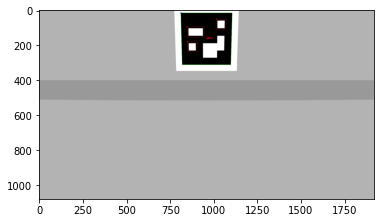

In [8]:
cv2.aruco.drawDetectedMarkers(img, corners, ids)
cv2.aruco.drawDetectedMarkers(img, rejected, borderColor=(255, 0, 0))

plt.imshow(img)

In [9]:
print(ids)

[[1]]


In [10]:
rvecs, tvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(corners,aruco_length,
                                                                       camera_matrix,
                                                                       camera_distortion)
print(rvecs[0][0])
print(tvecs)
H = utils.H_rvec_tvec(rvecs[0][0], tvecs[0][0])
utils.roundprint(H)

T_corr2 = np.array([[0, 0, 1, 0], [-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 1]]) 
H_corr = T_corr2 @ H @ np.linalg.inv(T_corr2)
print('H_corr')
utils.roundprint(H_corr)

rotmat, trans = utils.split_H_transform(H_corr)
rot = R.from_matrix(rotmat)
test = rot.as_euler('xyz')
print(test)

[-2.86397674e+00 -1.13177241e-04 -1.88614817e-04]
[[[-1.39356684e-03 -5.20328537e-01  1.93767015e+00]]]
 1.000  0.000  0.000 -0.001 
 0.000 -0.962  0.274 -0.520 
 0.000 -0.274 -0.962  1.938 
 0.000  0.000  0.000  1.000 


H_corr
-0.962  0.000  0.274  1.938 
 0.000  1.000  0.000  0.001 
-0.274  0.000 -0.962  0.520 
 0.000  0.000  0.000  1.000 


[ 3.14153081  0.27761591 -3.14146958]


In [11]:
for (rvec,tvec) in zip(rvecs,tvecs):
    overlay_frame = cv2.drawFrameAxes(img, camera_matrix, camera_distortion, rvec, tvec, aruco_length)



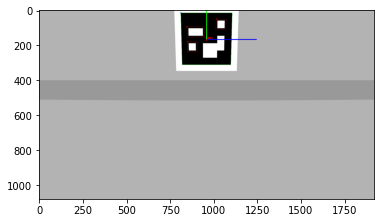

In [12]:
plt.imshow(img)

In [13]:
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as tf
import pytransform3d.rotations as rot
from pytransform3d.transform_manager import TransformManager

In [14]:
T_WC = tf.transform_from(rot.passive_matrix_from_angle(1, 0.3), np.array([1,1,1]), strict_check=True)
# 1: axis y - rotation by -0.3 rad around axis y

In [15]:
tm = TransformManager()
tm.add_transform("camera", "world", T_WC)

for id,(rvec,tvec) in enumerate(zip(rvecs,tvecs)):
    T_CM = tf.transform_from(rot.matrix_from_compact_axis_angle(rvec.flatten()), tvec)
    T_corrector = np.array([  [ 0,  0, 1, 0],
                               [ -1, 0, 0, 0],
                               [ 0,  -1, 0, 0],
                               [ 0, 0, 0, 1]])
    tm.add_transform("marker"+str(id), "camera", T_corrector @ T_CM @ np.linalg.inv(T_corrector))
    
# ee2object = tm.get_transform("end-effector", "object")



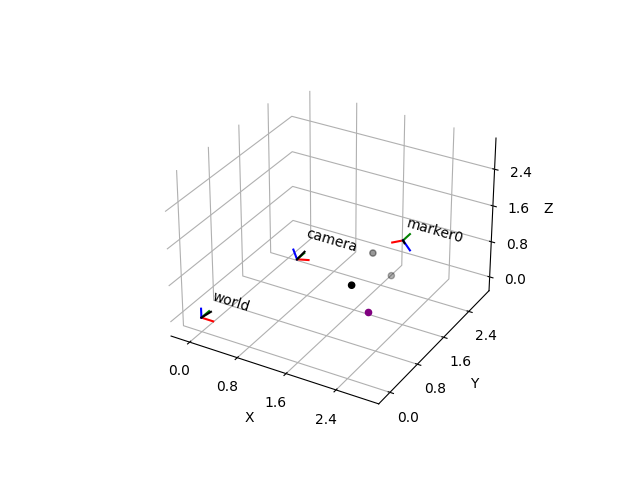

In [16]:
%matplotlib widget
ax = tm.plot_frames_in("world", s=0.2)
ax.set_xlim((-0.25, 3))
ax.set_ylim((-0.25, 3))
ax.set_zlim((-0.25, 3))
ax.scatter([2.4575, 2.5353, 2.2915], [0, 0.9822, 0.8877], [1.7207, 1.2679, 1.7207], c="black")
ax.scatter([2.7189], [0], [1.2679], c="purple")
plt.show()